In [ ]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline
# !pip install graphviz


Defaulting to user installation because normal site-packages is not writeable


In [2]:
class value:
    def __init__(self, data, _children=(),_op='',label=''):
        self.data = data
        self._backward= lambda:None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label=label

    def __repr__(self):
        return f"value(data={self.data})"

    
    def __add__(self,other):
        other = other if isinstance(other,value) else value(other) # a+1 throws error, by adding this we can perform this function. 
        out = value(self.data + other.data, {self,other},'+') 
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward=_backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,value) else value(other)  # a+1 throws error, by adding this we can perform this function. 
        out = value(self.data * other.data,{self,other}, '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward=_backward 
        return out

    def __pow__(self, other):
        assert isinstance(other,(int,float)), "only supports int & floats as of now"
        out = value(self.data**other, (self, ), f'**{other}')
        def _backward():
            self.grad += other*(self.data**(other-1))*out.grad
        out._backward=_backward
        return out
        
    def __rmul__(self,other): # like fallback, it checks if 2*a is performable, if not it checks if a knows how to perform the operation on 2.
        return self*other
    
    def __neg__(self):
        return self*(-1)

    def __sub__(self,other):
        return self + (-other)
    
    
    def __truediv__(self,other):
        return (self*other**-1)
    
    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = value(t, (self,) ,'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out

        # x_val = 2*self ; x_val.label = '2n'

        # # two_x = 2 * x_val
        # e_2x = x_val.exp(); e_2x.label = 'e^2n'
        # numerator = e_2x - 1; numerator.label = 'e^2n - 1'
        # denominator = e_2x + 1 ; denominator.label = 'e^2n + 1'
        # out = numerator / denominator 

        # # out = value(tanh, (self,), 'tanh')
        # out.label= 'tanh'

        # def _backward():
        #     tanh_squared = out**2
        #     self.grad += (1 - tanh_squared.data) * out.grad
        # out._backward = _backward

        return out

    def sigmoid(self):
        # x = self.data
        # sig = 1 / (1 + (math.exp(-x)))
        # out = value(sig, (self,), 'sigmoid')

        x_val = self
        neg_x = -x_val; neg_x.label = '-n'
        e_neg_x = neg_x.exp(); e_neg_x.label = 'e^-n'
        denominator = e_neg_x + 1; denominator.label = '1 + e^-n'
        out = value(1) / denominator
        
        out.label = 'sigmoid'
        # return out
        
        def _backward():
            self.grad += out.data * (1 - out.data) * out.grad
        out._backward = _backward
        return out

    def relu(self):
        x = self.data
        relu = x if x > 0 else 0
        out = value(relu, (self,), 'ReLU')

        def _backward():
            self.grad += (relu > 0) * out.grad
        out._backward = _backward
        return out

    def leaky_relu(self, alpha=0.01):
        # Leaky ReLU formula: x if x > 0 else alpha * x
        
        leaky_relu_val = self.data if self.data > 0 else self.data * alpha
        out = value(leaky_relu_val, (self,), 'Leaky ReLU')

        def _backward():
            # The gradient is 1 if input > 0, otherwise it is alpha
            self.grad += (1 if self.data > 0 else alpha) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):        
        # assert isinstance(self,(int,float)), "only supports int & floas as of now"
        
        x= self.data
        out=value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data*out.grad
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        # topo

        self.grad=1
        for node in reversed(topo):
            node._backward()

In [3]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'TD'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data:  %.4f | grad:  %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [83]:
# inputs
x1=value(2,label='x1')
x2=value(0.0,label='x2')
# weights
w1=value(-3,label='w1')
w2= value(1.0,label='w2')
# bias
b=value(6.8813735870195432,label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b;n.label='n'
o=n.tanh(); o.label='o'



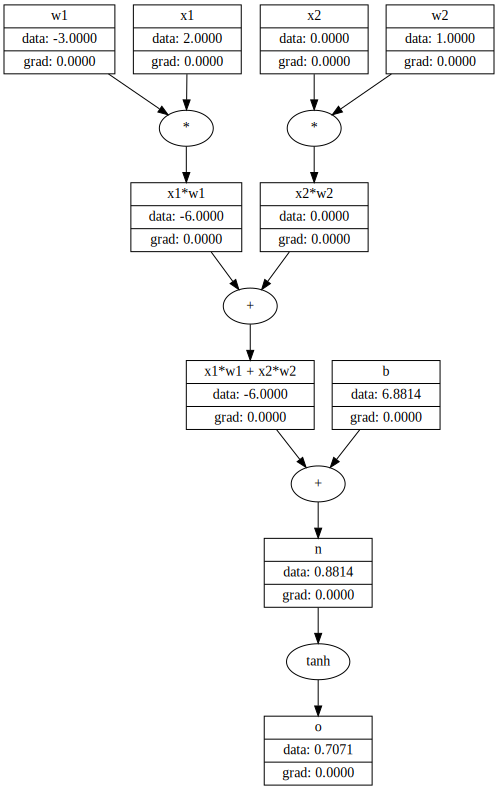

In [84]:
draw_dot(o)

# draw_dot(o).render('computational_graph', view=True)

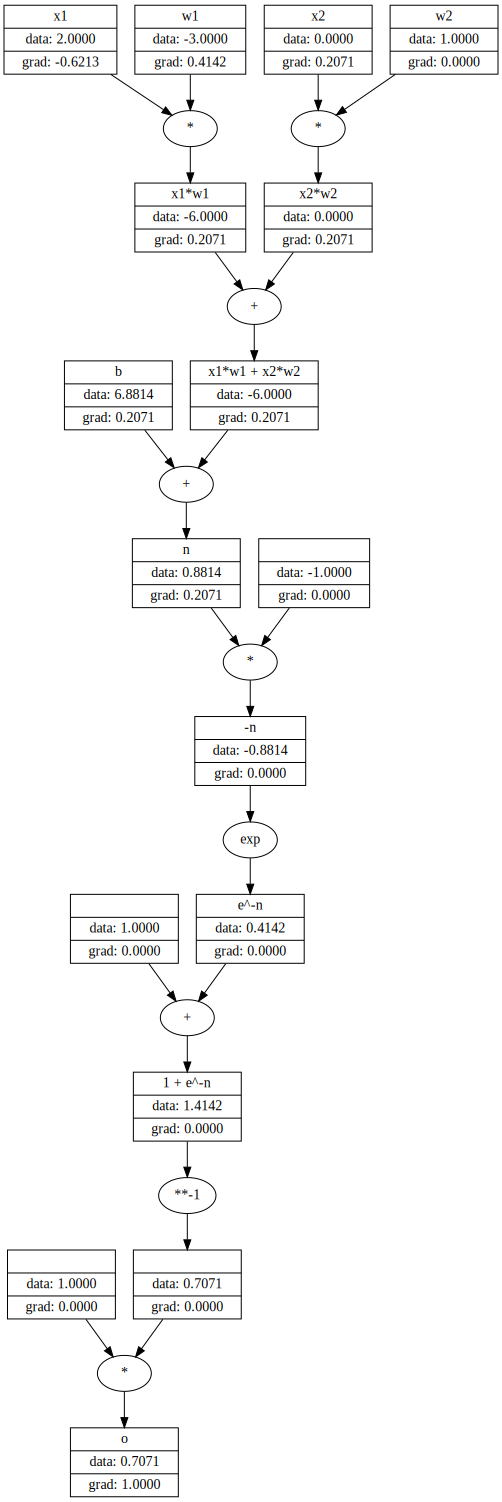

In [7]:
o.backward()
draw_dot(o)



In [74]:
class Neuron:
    def __init__(self,nin):
        self.w = [value(random.uniform(-1,1), label=f'w_{_}') for _ in range(nin)]
        self.b = value(random.uniform(-1,0), label='b')

    def __call__(self,x):
        # print(self.w,self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)),self.b)
        return act.tanh()
        
    def parameters(self):
        return self.w +  [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out)==1 else out

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # for neurons in self.neurons:
        #     ps=neuron.parameters()
        #     params.extend(ps)
        # return params
            
        
class MLP:
    def __init__(self, nin, nouts):
        sz=[nin]+nouts
        self.layers= [Layer(sz[i] , sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        
        for layer in self.layers:
            x=layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [89]:
#The training data
xs = [
    [12.0, 6], 
    [4.0, -2.0], 
]

ys = [1.0, -1.0]
ys_values = [value(y) for y in ys]

# Define the network
n = MLP(2, [2,2,  1])

In [90]:
epochs = 100
learning_rate = 0.001

# The training loop
for k in range(epochs):
    
    # Forward pass: Get predictions for all inputs
    ypred = [n(xi) for xi in xs]
    
    # Loss calculation: Mean Squared Error
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys_values, ypred)), start=value(0))
    
    # Zero all gradients
    for p in n.parameters():
        p.grad = 0.0
    
    loss.backward()
    
    # Update parameters using gradient descent
    for p in n.parameters():
        p.data -= learning_rate * p.grad
        
    if k % 10 == 0:
        print(f"Epoch {k+1}, Loss: {loss.data:.4f}")


# Comparing the Results after Training
# Run the final predictions
final_ypred = [n(xi) for xi in xs]

print("\n--- Final Predictions vs. True Labels ---")
for i, (pred, true) in enumerate(zip(final_ypred, ys)):
    print(f"Input {i}: Prediction = {pred.data:.4f}, True Label = {true} , Difference = {pred.data - true: .2f}")

Epoch 1, Loss: 2.9202
Epoch 11, Loss: 2.8523
Epoch 21, Loss: 2.7832
Epoch 31, Loss: 2.7138
Epoch 41, Loss: 2.6451
Epoch 51, Loss: 2.5782
Epoch 61, Loss: 2.5141
Epoch 71, Loss: 2.4536
Epoch 81, Loss: 2.3976
Epoch 91, Loss: 2.3466

--- Final Predictions vs. True Labels ---
Input 0: Prediction = -0.3213, True Label = 1.0 , Difference = -1.32
Input 1: Prediction = -0.2552, True Label = -1.0 , Difference =  0.74


In [91]:
draw_dot(loss).render('computational_graph', view=True)

'computational_graph.svg'

In [79]:
len(n.parameters())

7

In [61]:
for i, w in enumerate(n.parameters()):
    print(f"Param {i}: id = {id(w)}, data = {w.data:.4f}")


Param 0: id = 128589391214720, data = -0.7621
Param 1: id = 128589391204208, data = 0.3002
Param 2: id = 128589391210928, data = -0.1674
Param 3: id = 128589391215008, data = -0.1876
Param 4: id = 128589391214288, data = -0.5715
Param 5: id = 128589391214240, data = -0.8246
Param 6: id = 128589391200368, data = 0.7642
Param 7: id = 128589391201136, data = -0.7585
Param 8: id = 128589391207088, data = -0.0638
Param 9: id = 128589391202720, data = -0.7541
Param 10: id = 128589391201664, data = -0.8397
Param 11: id = 128589391216448, data = -0.3647
Param 12: id = 128589391208240, data = -0.5305
Param 13: id = 128589391200752, data = 0.3027
Param 14: id = 128589391204784, data = -0.1741
Param 15: id = 128589391213952, data = -0.7666
Param 16: id = 128589391208528, data = -0.6683


In [92]:
# --- Inspection Script ---

# 1. Initialize your network
# n = MLP(3, [4, 4, 1])

# 2. Iterate and print parameters
for i, layer in enumerate(n.layers):
    print(f"--- Layer {i+1} ---")
    for j, neuron in enumerate(layer.neurons):
        # Extract the raw numbers from the 'value' objects for clarity
        weights = [p.data for p in neuron.w]
        bias = neuron.b.data
        
        print(f"  Neuron {j+1}:")
        print(f"    Weights: {weights}")
        print(f"    Bias: {bias}")
    print() 

--- Layer 1 ---
  Neuron 1:
    Weights: [-0.797501287098584, 0.6716978749303191]
    Bias: -0.2595600712071837
  Neuron 2:
    Weights: [0.8096978693520278, 0.900131854179094]
    Bias: -0.8472537146380629

--- Layer 2 ---
  Neuron 1:
    Weights: [0.6998434614033486, -0.6164199144551982]
    Bias: -0.010547089362804718
  Neuron 2:
    Weights: [0.42026527754230725, 0.2808896351771728]
    Bias: -0.3669985789446797

--- Layer 3 ---
  Neuron 1:
    Weights: [0.013869086913317608, -0.734889412670611]
    Bias: -0.6643761154305119

